### Importing necessary libraries 

In [271]:
from time import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline
from scipy.stats import skew
import random
import requests
from scrapy.selector import Selector
from scrapy.http import HtmlResponse
import pandas as pd
import numpy as np
from time import sleep
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, Imputer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer 
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor,ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from scipy.stats import randint
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from IPython.display import display

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'


#### Loading scraped data

In [3]:
import pickle
data = pickle.load( open( "data_df_clean.p", "rb" ) )

#### Creating new "total_reviews" variable

In [5]:
data['total_reviews'] = data.user_reviews + data.critic_reviews

#### Creating predictors and target 

In [ ]:
X = data.drop(['id', 'name','rating', 'rating_class'], axis=1)
y = data.rating.values

#### Train/Test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=412)

#### Vectorize columns using CountVectorizer

In [89]:
cvr = CountVectorizer(binary=True, 
                      strip_accents='unicode',
                      max_features = 100,
                      tokenizer=(lambda x: x.split('|')))

X_train_cast = cvr.fit_transform(X_train.cast).todense()
names = cvr.get_feature_names()
cast_df = pd.DataFrame(X_train_cast, columns=names)

for i in cast_df.columns:
    X_train.insert(len(X_train.columns)-1,"actor_"+i,cast_df[i].values)


X_test_cast = cvr.transform(X_test.cast).todense()
names = cvr.get_feature_names()
cast_df = pd.DataFrame(X_test_cast, columns=names)

for i in cast_df.columns:
    X_test.insert(len(X_test.columns)-1,"actor_"+i,cast_df[i].values)


cvr = CountVectorizer(binary=True, 
                      strip_accents='unicode')

X_train_genre = cvr.fit_transform(X_train.genre).todense()
names = cvr.get_feature_names()
genre_df = pd.DataFrame(X_train_genre, columns=names)

for i in genre_df.columns:
    X_train.insert(len(X_train.columns)-1,"genre_"+i,genre_df[i].values)
X_train = X_train.drop(['genre', 'cast'], axis=1)

X_test_genre = cvr.transform(X_test.genre).todense()
names = cvr.get_feature_names()
genre_df = pd.DataFrame(X_test_genre, columns=names)

for i in genre_df.columns:
    X_test.insert(len(X_test.columns)-1,"genre_"+i,genre_df[i].values)
X_test = X_test.drop(['genre', 'cast'], axis=1)

#### Standardize the predictors' variables

In [ ]:
ss = StandardScaler()

Xs_train = ss.fit_transform(X_train)

Xs_test = ss.transform(X_test)

#### Cross-validation: evaluating estimator performance
<li> every estimator exposes a score method that can judge the quality of the fit (or the prediction) on new data.

In [272]:
cv = StratifiedKFold(n_splits=3,shuffle=True,random_state=42)
knn = KNeighborsRegressor()
dtr = DecisionTreeRegressor()
bdt = BaggingRegressor(base_estimator=dtr, n_estimators=500, n_jobs=2)
rf = RandomForestRegressor()
et = ExtraTreeRegressor()
lin_reg = LinearRegression()
el_net = ElasticNet()
ab = AdaBoostRegressor(base_estimator=dtr, n_estimators=500)
gb = GradientBoostingRegressor(n_estimators=1000)
catboost = CatBoostRegressor()
# define a function to compute R^2 and MSE
def score(model, name):
    s = cross_val_score(model, Xs_train, y_train, cv=cv)
    print("{} CV Score:\t{:0.3} ± {:0.3}".format(name, s.mean().round(3), s.std().round(3)))
    model.fit(Xs_train,y_train)
    y_pred = model.predict(Xs_test)
    print "Train score:\t {:.4f}".format(model.score(Xs_train, y_train))
    print "Test score:\t {:.4f}".format(model.score(Xs_test, y_test))
    print "MSE:\t\t {:.4f}\n".format(mean_squared_error(y_test, y_pred))

score(knn, "KNeighbors")
score(dtr, "Decision Tree")
score(bdt, "Bagging DT")
score(rf, "Random Forest")
score(et, "Extra Trees")
score(lin_reg, "Linear")
score(el_net, "Elastic Net")
score(ab, "Ada Boost")
score(gb, "Gradient Boost")
score(catboost, "CatBoost")

KNeighbors CV Score:	0.071 ± 0.018
Train score:	 0.4020
Test score:	 0.1045
MSE:		 1.2743

Decision Tree CV Score:	-0.427 ± 0.072
Train score:	 1.0000
Test score:	 -0.2787
MSE:		 1.8197

Bagging DT CV Score:	0.273 ± 0.004
Train score:	 0.9010
Test score:	 0.2643
MSE:		 1.0469

Random Forest CV Score:	0.205 ± 0.011
Train score:	 0.8556
Test score:	 0.2108
MSE:		 1.1230

Extra Trees CV Score:	-0.474 ± 0.014
Train score:	 1.0000
Test score:	 -0.2786
MSE:		 1.8194

Linear CV Score:	0.126 ± 0.034
Train score:	 0.1888
Test score:	 -2008697271831460839424.0000
MSE:		 2858414734775072849920.0000

Elastic Net CV Score:	-0.001 ± 0.0
Train score:	 0.0000
Test score:	 -0.0008
MSE:		 1.4241

Ada Boost CV Score:	0.243 ± 0.018
Train score:	 0.9985
Test score:	 0.2515
MSE:		 1.0651

Gradient Boost CV Score:	0.138 ± 0.035
Train score:	 0.8221
Test score:	 0.1878
MSE:		 1.1557

CatBoost CV Score:	0.917 ± 0.048
Train score:	 0.7681
Test score:	 1.0495
MSE:		 1.0495



### To understand which functions are more important for rating forecasting, I will use the following models:
<li> DecisionTreeRegressor model
<li> AdaBoostRegressor model
<li> BaggingRegressor model
<li> RandomForestRegressor model
<li> GradientBoostingRegressor model

### DecisionTreeRegressor model

In [207]:
# parameters to tune
param_grid = {"splitter": ["best", "random"],
              "max_depth": [None, 3, 5],
              "max_features": [1.0, 0.5, 0.1],
              "min_samples_split": [2, 3, 4],
              "min_samples_leaf": [10, 15, 20],
              "criterion": ["mse", "friedman_mse", "mae"]}
dtr = DecisionTreeRegressor()
grid_search_dtr = GridSearchCV(dtr, param_grid=param_grid, verbose=1, cv=cv, n_jobs=2)
grid_search_dtr.fit(Xs_train, y_train)

Fitting 3 folds for each of 486 candidates, totalling 1458 fits


[Parallel(n_jobs=2)]: Done 240 tasks      | elapsed:    3.5s
[Parallel(n_jobs=2)]: Done 1124 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done 1374 tasks      | elapsed:  4.0min
[Parallel(n_jobs=2)]: Done 1458 out of 1458 | elapsed:  4.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=2,
       param_grid={'splitter': ['best', 'random'], 'min_samples_leaf': [10, 15, 20], 'min_samples_split': [2, 3, 4], 'criterion': ['mse', 'friedman_mse', 'mae'], 'max_features': [1.0, 0.5, 0.1], 'max_depth': [None, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [208]:
# best model estimator
dtr_best_model = grid_search_dtr.best_estimator_
print dtr_best_model

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=0.5,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='random')


In [209]:
# best tuned parameters
dtr_best_parameters = grid_search_dtr.best_params_
print dtr_best_parameters

{'splitter': 'random', 'min_samples_leaf': 10, 'min_samples_split': 2, 'criterion': 'mse', 'max_features': 0.5, 'max_depth': None}


In [262]:
# best score
dtr_best_score = grid_search_dtr.best_score_
print dtr_best_score

0.170959892448


In [263]:
# model predictions
y_pred = dtr_best_model.predict(Xs_test)

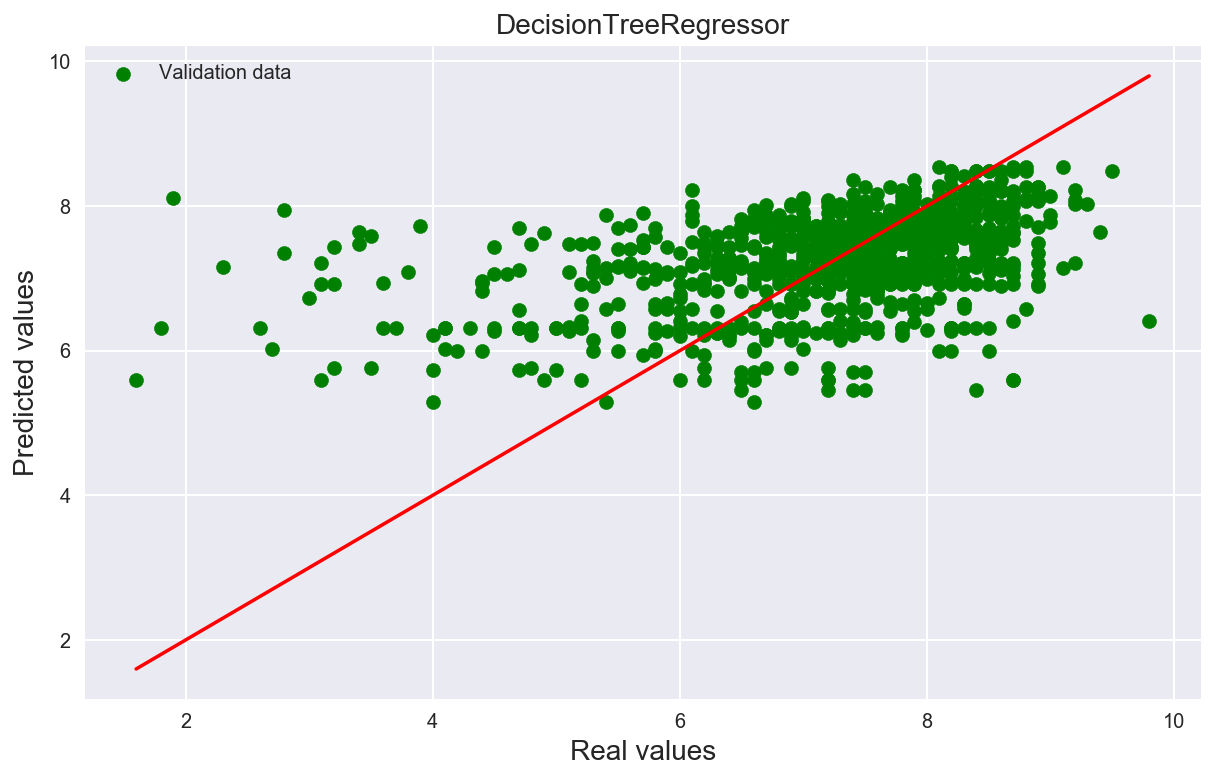

In [264]:
# Plot predictions
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(y_test, y_pred, c = "green", marker = "o", label = "Validation data",)
plt.title("DecisionTreeRegressor", fontsize=14)
plt.ylabel("Predicted values", fontsize=14)
plt.xlabel("Real values", fontsize=14)
plt.legend(loc = "upper left")
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], c = "red")
plt.show()

fig, ax = plt.subplots(figsize=(16,8))
importances.plot(kind='bar', ax=ax, fontsize=14)
plt.title("Top 10 important features in 5 Models", fontsize=14)


In [265]:
dtr_feature_importances = pd.DataFrame(dtr_best_model.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance'])
top_10 = dtr_feature_importances.sort_values(by='importance', ascending=True).tail(10)

In [266]:
top_10.sort_values(by='importance', ascending=False)

,importance
votes,0.143009
genre_tv,0.141441
critic_reviews,0.125020
n_episodes,0.120490
user_reviews,0.061017
genre_show,0.054981
runtime_tvmaze,0.041753
genre_talk,0.041430
genre_comedy,0.039909
start_date,0.038101


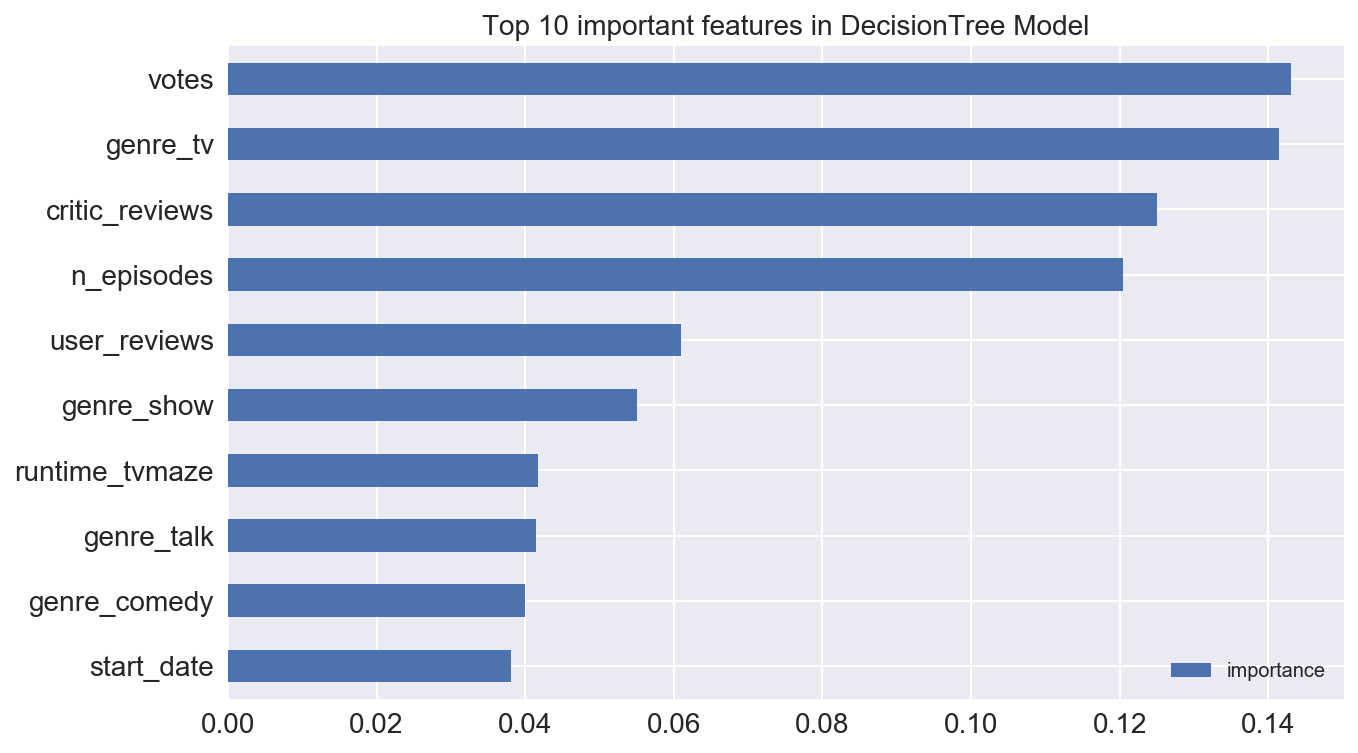

In [267]:
top_10.plot(kind = "barh", figsize=(10,6), fontsize=14)
plt.title("Top 10 important features in DecisionTree Model", fontsize=14)
plt.show()

### AdaBoostRegressor model

In [253]:
# parameters to tune
param_grid = {"n_estimators": [400, 500, 600],
             "loss": ["linear", "square", "exponential"],
             }
dtr = DecisionTreeRegressor()
abr = AdaBoostRegressor(base_estimator = dtr)

# run grid search
grid_search_abr = GridSearchCV(abr, param_grid=param_grid, cv=cv, n_jobs=2, verbose=1)
grid_search_abr.fit(Xs_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=2)]: Done  27 out of  27 | elapsed:  4.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
       error_score='raise',
       estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=50,
         random_state=None),
       fit_params={}, iid=True, n_jobs=2,
       param_grid={'n_estimators': [400, 500, 600], 'loss': ['linear', 'square', 'exponential']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [254]:
# best model estimator
abr_best_parameters = grid_search_abr.best_params_
print abr_best_parameters

{'n_estimators': 600, 'loss': 'linear'}


In [255]:
# best tuned parameters
abr_best_model = grid_search_abr.best_estimator_
print abr_best_model

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=600,
         random_state=None)


In [256]:
# best score
abr_best_score = grid_search_abr.best_score_
print abr_best_score

0.244581125297


In [257]:
# model predictions
y_pred = grid_search_abr.predict(Xs_test)

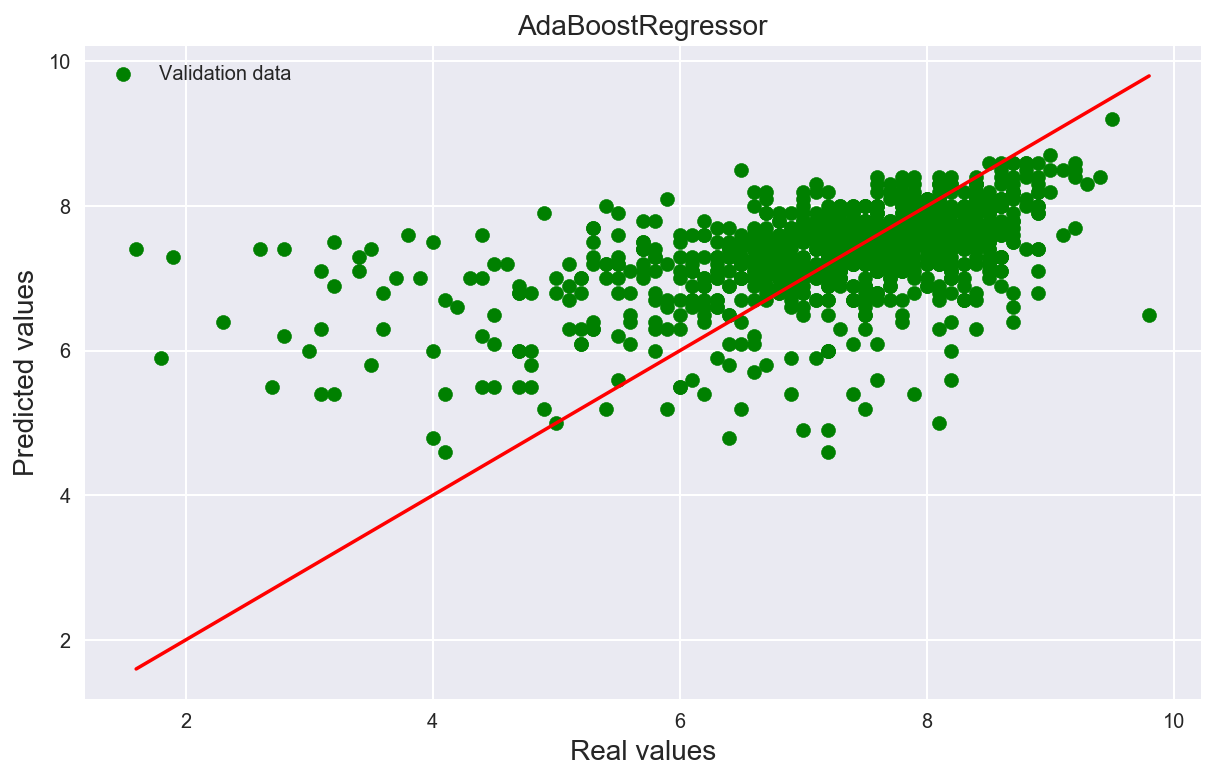

In [258]:
# Plot predictions
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(y_test, y_pred, c = "green", marker = "o", label = "Validation data",)
plt.title("AdaBoostRegressor", fontsize=14)
plt.ylabel("Predicted values", fontsize=14)
plt.xlabel("Real values", fontsize=14)
plt.legend(loc = "upper left")
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], c = "red")
plt.show()

#### Top 10 important features

In [259]:
abr_feature_importances = pd.DataFrame(abr_best_model.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance'])
top_10 = abr_feature_importances.sort_values(by='importance', ascending=True).tail(10)

In [260]:
top_10.sort_values(by='importance', ascending=False)

,importance
votes,0.195108
n_episodes,0.190529
start_date,0.122017
user_reviews,0.090177
runtime_tvmaze,0.086145
total_reviews,0.083581
critic_reviews,0.059590
genre_reality,0.016030
genre_tv,0.014686
genre_comedy,0.013494


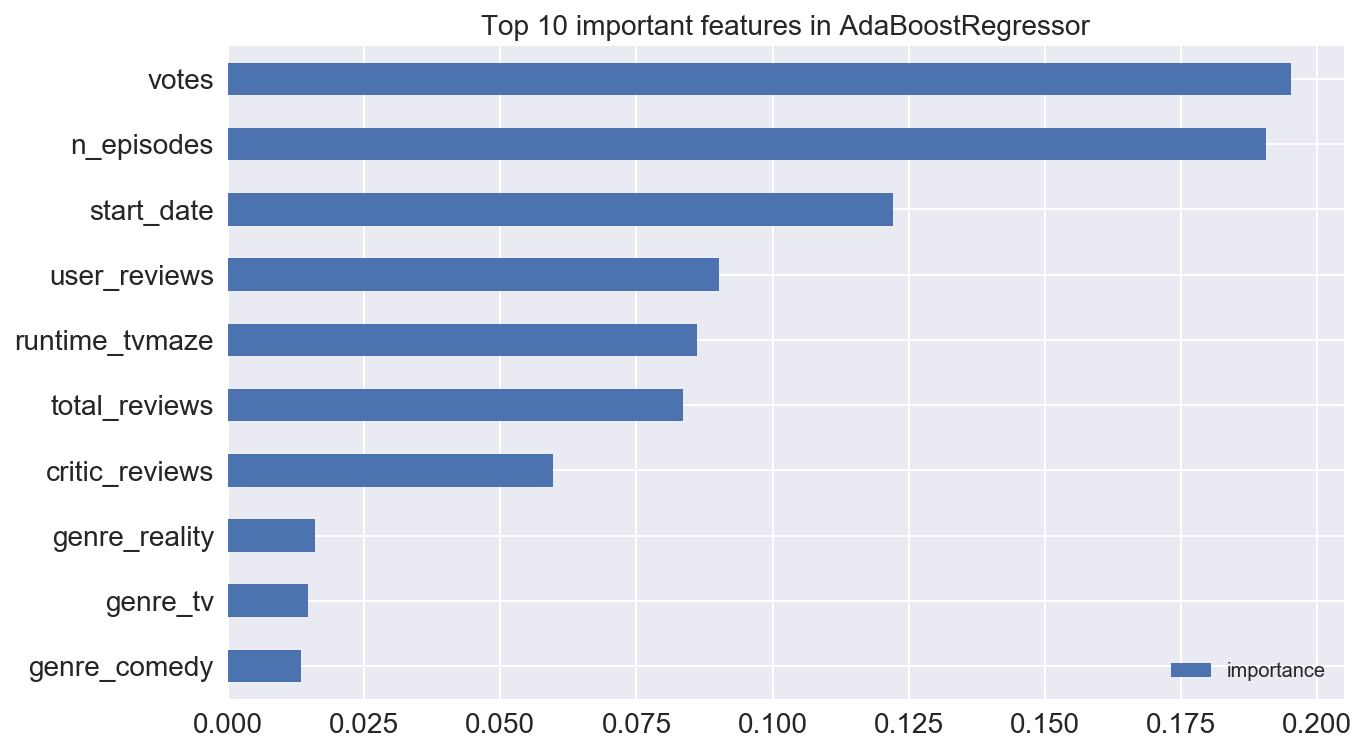

In [261]:
top_10.plot(kind = "barh", figsize=(10,6), fontsize=14)
plt.title("Top 10 important features in AdaBoostRegressor", fontsize=14)
plt.show()

### BaggingRegressor model

In [147]:
# parameters to tune
param_grid = {"n_estimators": [400, 500, 600],
              "max_samples": [1.0, 0.5, 0.1],
              "max_features": [1.0, 0.5, 0.1]
             }
br = BaggingRegressor(base_estimator = dtr)

# run grid search
grid_search_br = GridSearchCV(br, param_grid=param_grid, cv=cv, n_jobs=2, verbose=1)
grid_search_br.fit(Xs_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:  5.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
       error_score='raise',
       estimator=BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,...n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=2,
       param_grid={'n_estimators': [400, 500, 600], 'max_samples': [1.0, 0.5, 0.1], 'max_features': [1.0, 0.5, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [172]:
# best model estimator
br_best_model = grid_search_br.best_estimator_
print br_best_model

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.5, n_estimators=400, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)


In [156]:
# best tuned parameters
br_best_parameters = grid_search_br.best_params_
print br_best_parameters

{'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 400}


In [157]:
# best score
br_best_score = grid_search_br.best_score_
print br_best_score

0.286270652492


In [248]:
# model predictions
y_pred = br_best_model.predict(Xs_test)

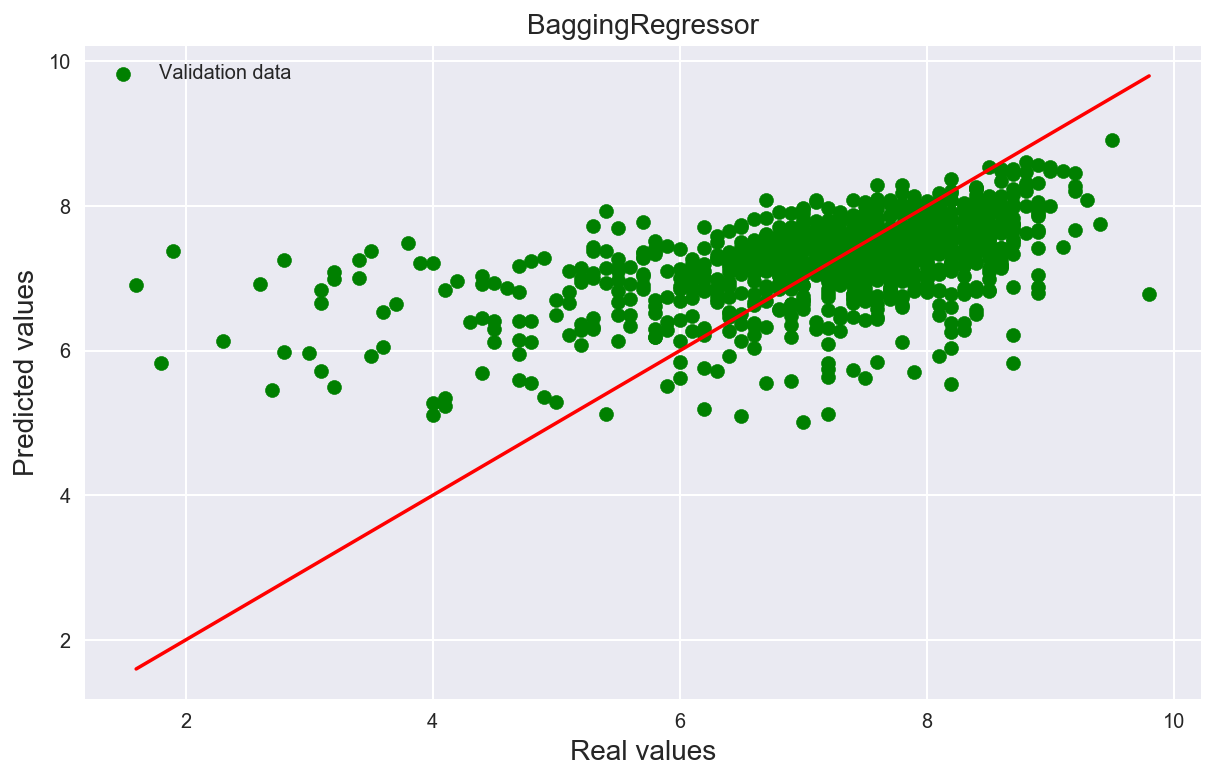

In [249]:
# Plot predictions
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(y_test, y_pred, c = "green", marker = "o", label = "Validation data",)
plt.title("BaggingRegressor", fontsize=14)
plt.ylabel("Predicted values", fontsize=14)
plt.xlabel("Real values", fontsize=14)
plt.legend(loc = "upper left")
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], c = "red")
plt.show()

#### Top 10 important features

In [230]:
br_feature_importances = np.mean([
    tree.feature_importances_ for tree in br_best_model.estimators_
], axis=0)

In [220]:
br_feature_importances_df = pd.DataFrame(br_feature_importances,
                                   index = X_train.columns,
                                    columns=['importance'])
top_10 = br_feature_importances_df.sort_values(by='importance', ascending=True).tail(10)

In [221]:
top_10.sort_values(by='importance', ascending=False)

,importance
votes,0.207929
n_episodes,0.178312
start_date,0.121743
user_reviews,0.082677
total_reviews,0.075285
runtime_tvmaze,0.074620
critic_reviews,0.064369
genre_tv,0.018744
genre_reality,0.018357
genre_documentary,0.014211


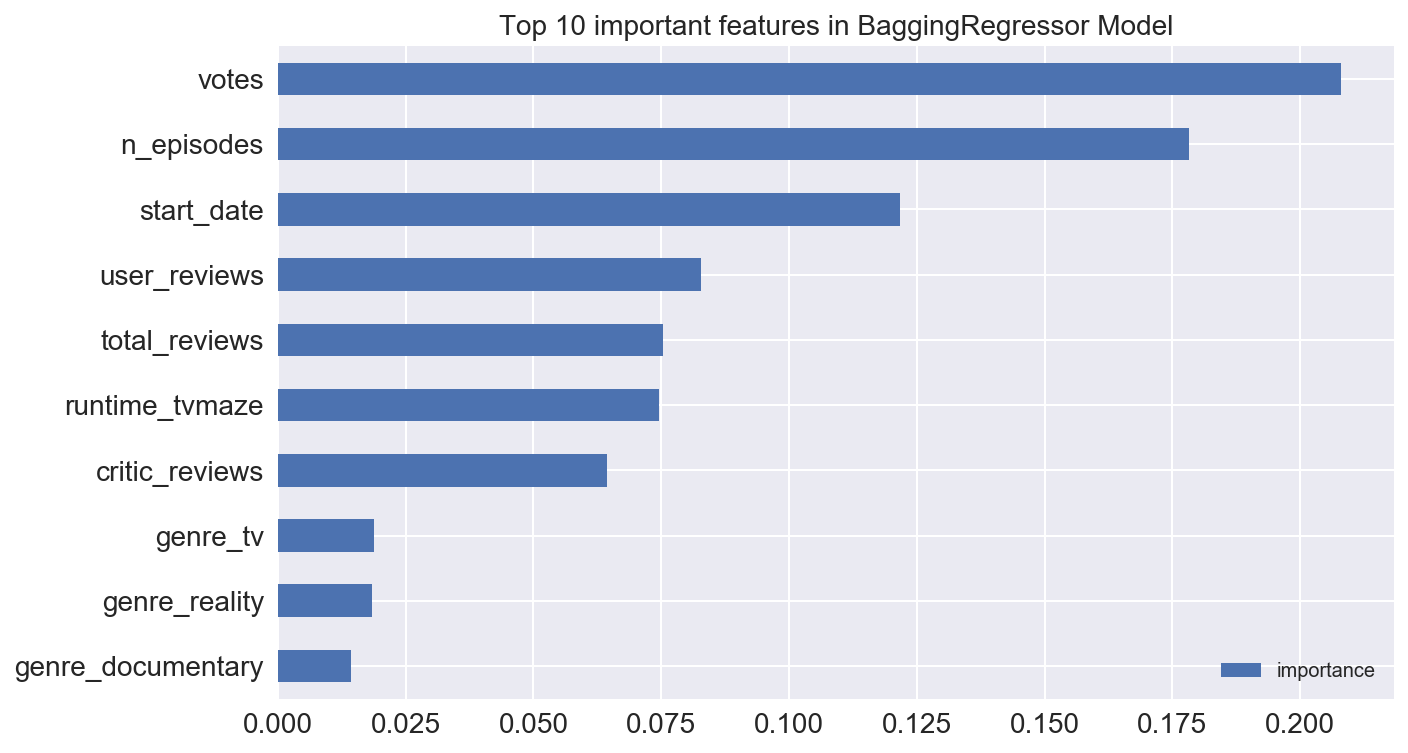

In [178]:
top_10.plot(kind = "barh", figsize=(10,6), fontsize=14)
plt.title("Top 10 important features in BaggingRegressor Model", fontsize=14)
plt.show()

### RandomForestRegressor model

In [179]:
# parameters to tune
param_grid = {"n_estimators": [190, 200, 210],
              "bootstrap": [True, False],
              "min_samples_leaf": [1, 2, 3],
              "max_features": ["auto", "sqrt", "log2", None],
              "max_depth": [None, 3, 5]
             }
rf = RandomForestRegressor()
grid_search_rf = GridSearchCV(rf, param_grid=param_grid, verbose=1, cv=cv, n_jobs=2)
grid_search_rf.fit(Xs_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  4.3min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed: 23.1min
[Parallel(n_jobs=2)]: Done 648 out of 648 | elapsed: 27.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=2,
       param_grid={'n_estimators': [190, 200, 210], 'max_features': ['auto', 'sqrt', 'log2', None], 'bootstrap': [True, False], 'max_depth': [None, 3, 5], 'min_samples_leaf': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [180]:
# best model estimator
rf_best_model = grid_search_rf.best_estimator_
print rf_best_model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=210, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


In [181]:
# best tuned parameters
rf_best_parameters = grid_search_rf.best_params_
print rf_best_parameters

{'max_features': 'auto', 'n_estimators': 210, 'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 3}


In [182]:
# best score
rf_best_score = grid_search_rf.best_score_
print rf_best_score

0.275756872052


In [242]:
# model predictions
y_pred = rf_best_model.predict(Xs_test)

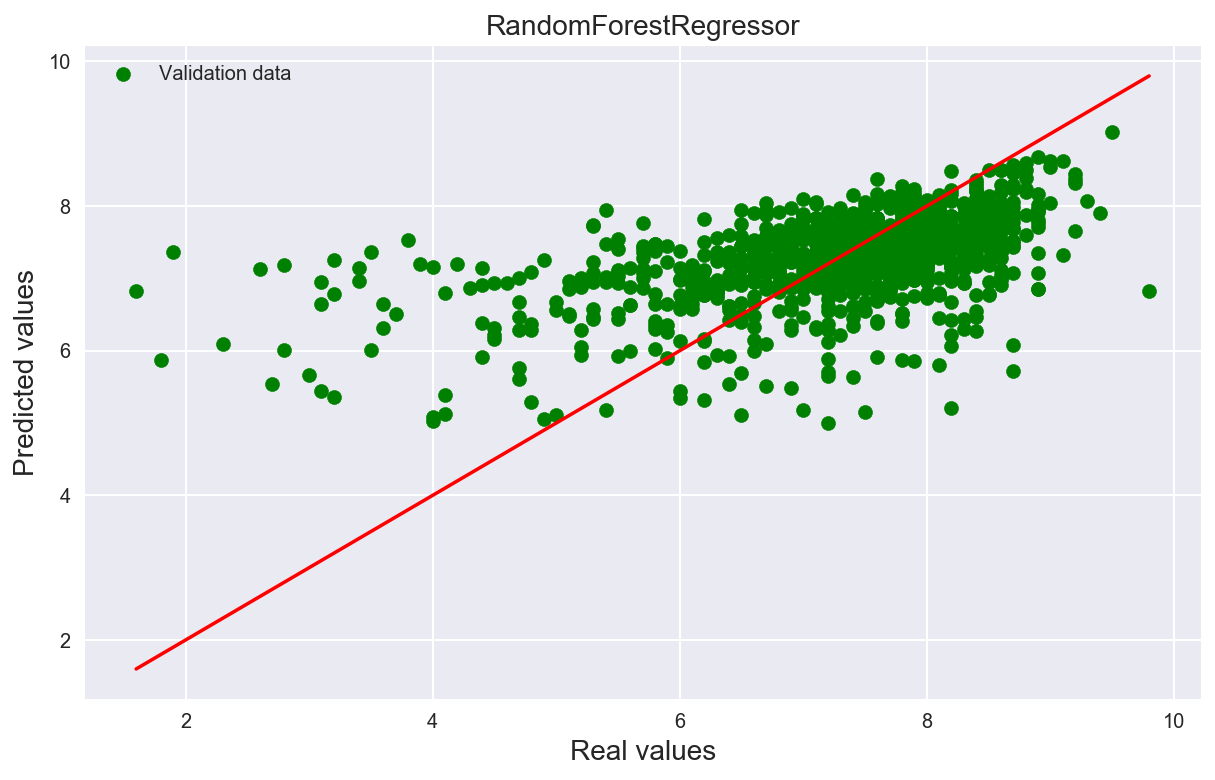

In [245]:
# Plot predictions
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(y_test, y_pred, c = "green", marker = "o", label = "Validation data",)
plt.title("RandomForestRegressor", fontsize=14)
plt.ylabel("Predicted values", fontsize=14)
plt.xlabel("Real values", fontsize=14)
plt.legend(loc = "upper left")
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], c = "red")
plt.show()

#### Top 10 important features

In [222]:
rf_feature_importances = pd.DataFrame(rf_best_model.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance'])
top_10 = rf_feature_importances.sort_values(by='importance', ascending=True).tail(10)

In [223]:
top_10.sort_values(by='importance', ascending=False)

,importance
votes,0.231293
n_episodes,0.192160
start_date,0.131265
user_reviews,0.083422
total_reviews,0.076554
runtime_tvmaze,0.068726
critic_reviews,0.067732
genre_reality,0.023674
genre_tv,0.022957
genre_show,0.015895


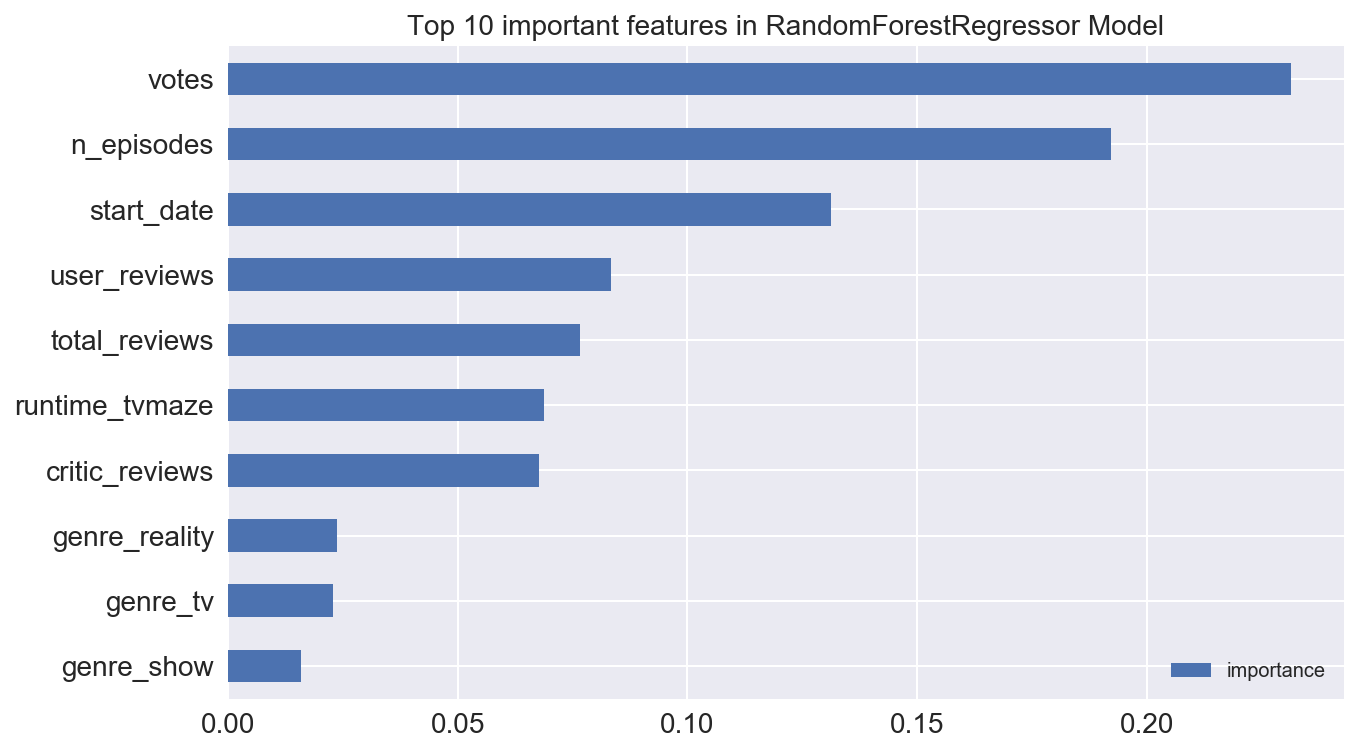

In [224]:
top_10.plot(kind = "barh", figsize=(10,6), fontsize=14)
plt.title("Top 10 important features in RandomForestRegressor Model", fontsize=14)
plt.show()

### GradientBoostingRegressor model

In [194]:
# parameters to tune
param_grid = {"learning_rate" : [0.5, 0.3, 0.1],
              "max_depth" :   [4,6,None],
              "min_samples_leaf": [3, 9, 17],
              "max_features": [1.0, 0.3, 0.1],
              "n_estimators": [1000]
              
             }
gb = GradientBoostingRegressor()
# run grid search
grid_search_gb = GridSearchCV(gb, param_grid=param_grid, verbose=1, cv=cv, n_jobs=2)
grid_search_gb.fit(Xs_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  4.1min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed: 19.8min
[Parallel(n_jobs=2)]: Done 243 out of 243 | elapsed: 30.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
       error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=2,
       param_grid={'max_features': [1.0, 0.3, 0.1], 'n_estimators': [1000], 'learning_rate': [0.5, 0.3, 0.1], 'max_depth': [4, 6, None], 'min_samples_leaf': [3, 9, 17]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [195]:
# best model estimator
gb_best_model = grid_search_gb.best_estimator_
print gb_best_model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=0.1,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=17, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)


In [196]:
# best tuned parameters
gb_best_parameters = grid_search_gb.best_params_
print gb_best_parameters

{'max_features': 0.1, 'n_estimators': 1000, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 17}


In [197]:
# best model score
gb_best_score = grid_search_gb.best_score_
print gb_best_score

0.253552545513


In [246]:
# model predictions
y_pred = gb_best_model.predict(Xs_test)

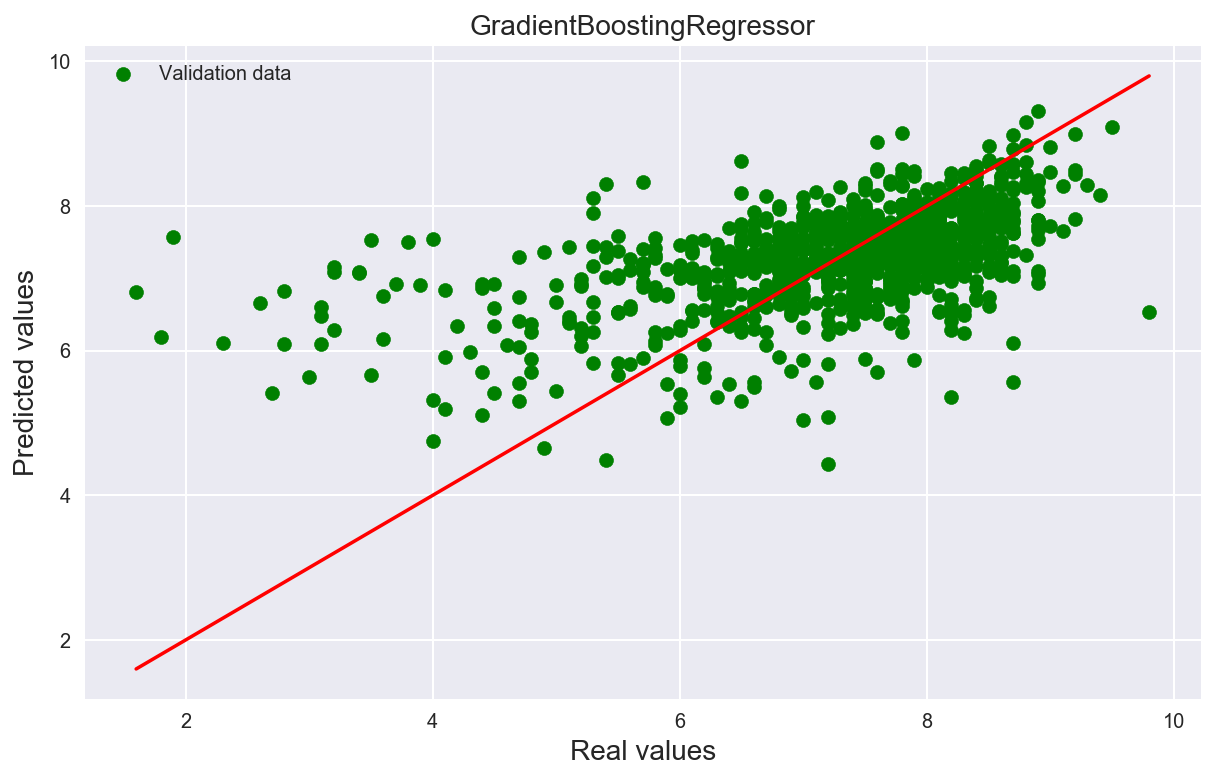

In [247]:
# Plot predictions
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(y_test, y_pred, c = "green", marker = "o", label = "Validation data",)
plt.title("GradientBoostingRegressor", fontsize=14)
plt.ylabel("Predicted values", fontsize=14)
plt.xlabel("Real values", fontsize=14)
plt.legend(loc = "upper left")
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], c = "red")
plt.show()

#### Top 10 important features

In [225]:
gb_feature_importances = pd.DataFrame(gb_best_model.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance'])
top_10 = gb_feature_importances.sort_values(by='importance', ascending=True).tail(10)

In [226]:
top_10.sort_values(by='importance', ascending=False)

,importance
n_episodes,0.145935
votes,0.142186
runtime_tvmaze,0.099446
total_reviews,0.095119
start_date,0.093843
user_reviews,0.091262
critic_reviews,0.063508
genre_comedy,0.014268
genre_drama,0.011208
genre_animation,0.010586


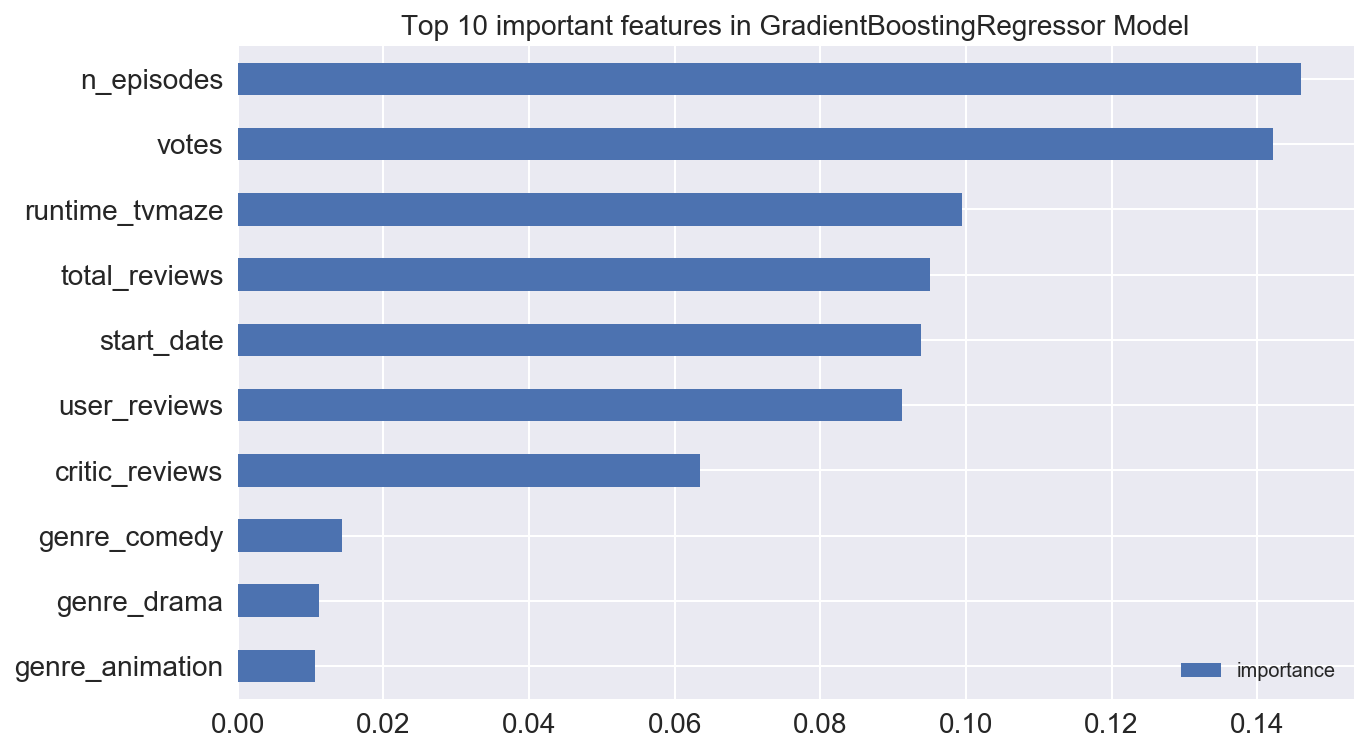

In [227]:
top_10.plot(kind = "barh", figsize=(10,6), fontsize=14)
plt.title("Top 10 important features in GradientBoostingRegressor Model", fontsize=14)
plt.show()

### Compare feature importance by each model

In [268]:
importances = pd.DataFrame(zip(dtr_best.feature_importances_,abr_best_model.feature_importances_,\
            br_feature_importances, rf_best_model.feature_importances_,\
            gb_best_model.feature_importances_),
            index=X_train.columns, columns=['dtr_importance', 'abr_importance', 'br_importance', 'rf_importance',\
                                           'gb_importance',]).sort_values('rf_importance',ascending=False)               
importances = importances.head(10)

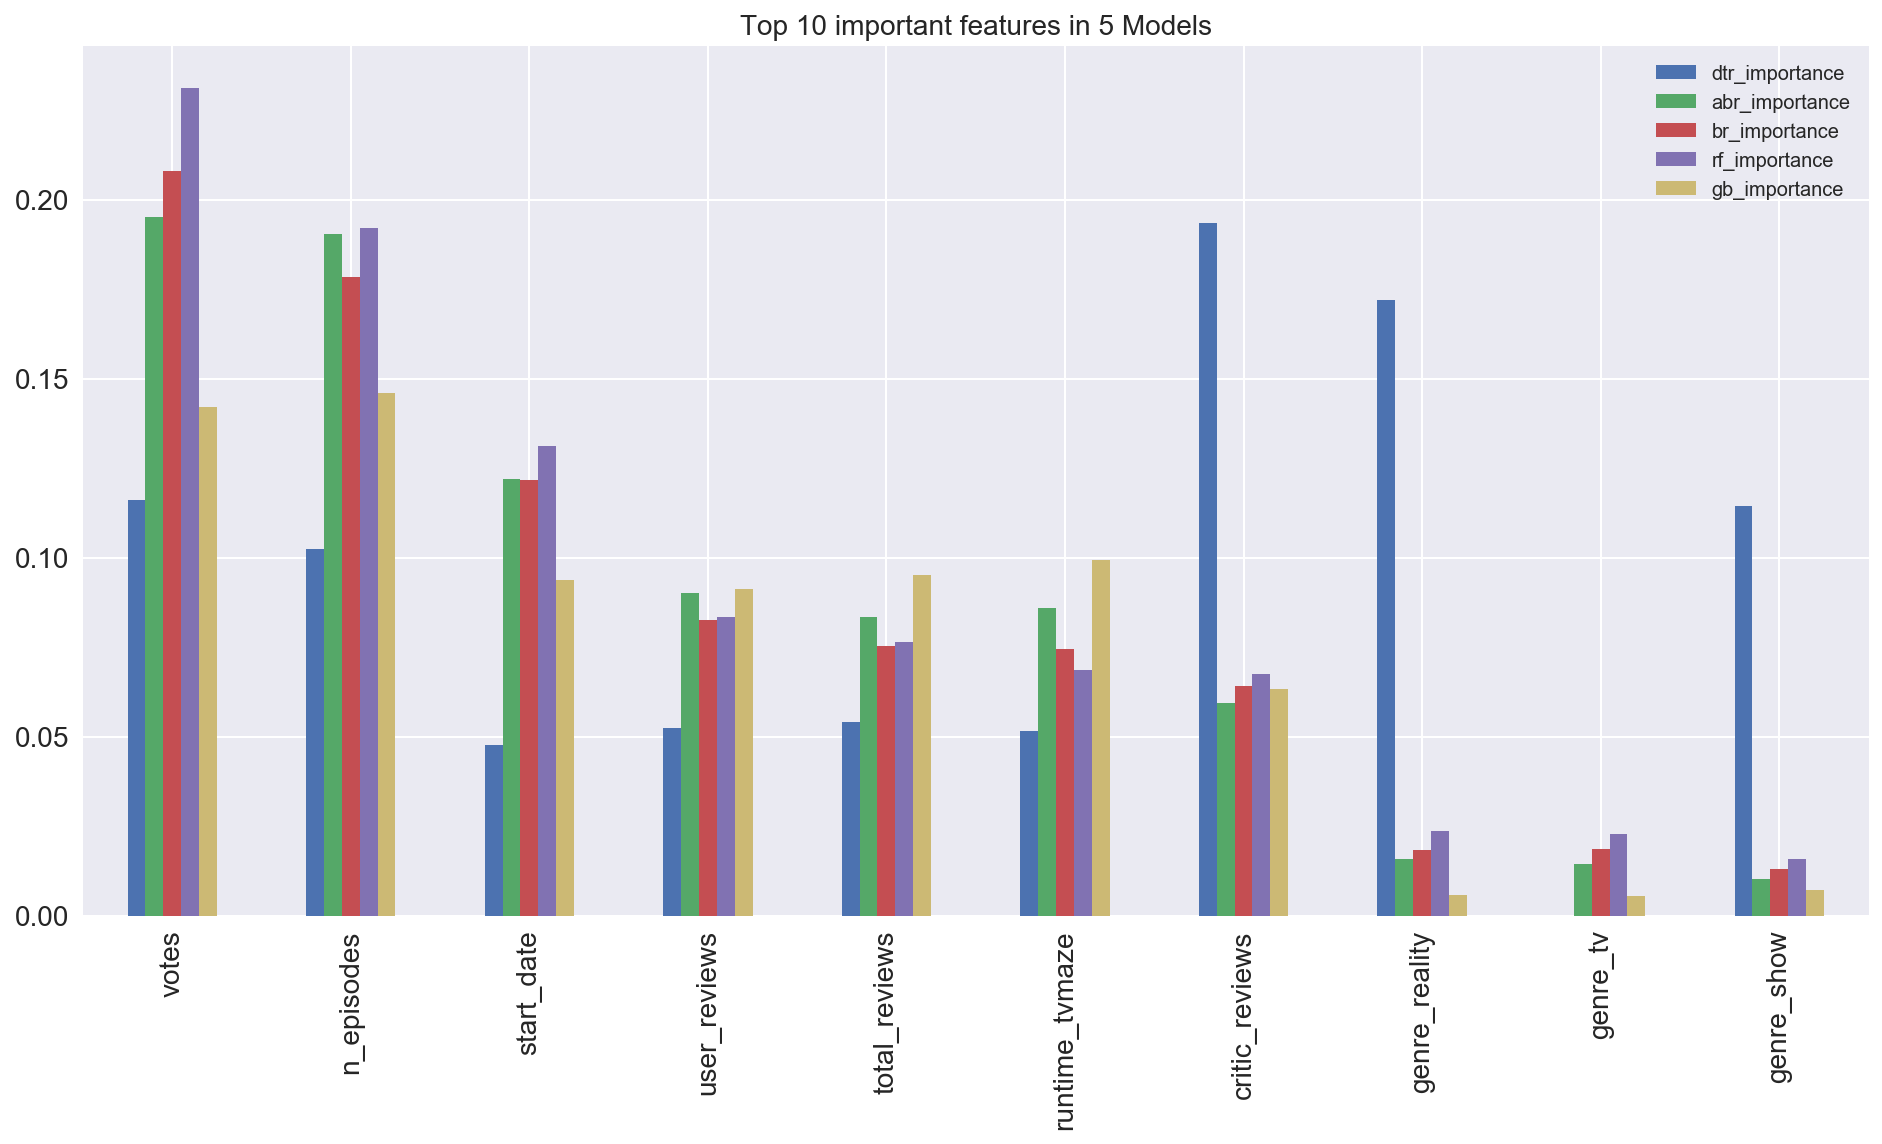

In [269]:
fig, ax = plt.subplots(figsize=(16,8))
importances.plot(kind='bar', ax=ax, fontsize=14)
plt.title("Top 10 important features in 5 Models", fontsize=14)


The above figure shows the relative importance of top 10 features included in our 5 models.